In [193]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
import torch
import torch.nn as nn
import torch.nn.functional as F          # adds some efficiency
from torch.utils.data import Dataset, DataLoader  # lets us load data in batches
from torchvision import datasets, transforms
import h5py


import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix  # for evaluating results
import matplotlib.pyplot as plt
import os
from preprocessing.dataset_img import CustomDataset
%matplotlib inline

In [195]:
transform = transforms.ToTensor()


In [196]:
base_path = "../"


train_dataset = CustomDataset(
    base_dir=base_path,
    h5_file="test_training_covid_img.h5",
    transform=transform,
    is_debug=True,
)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

test_dataset = CustomDataset(
    base_dir=base_path,
    h5_file="test_testing_covid_img.h5",
    transform=transform,
    is_debug=True,
)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

/develop/src
../test_training_covid_img.h5
/develop/src
../test_testing_covid_img.h5


In [197]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5, 1)
        self.conv2 = nn.Conv2d(10, 5, 3, 1)
        self.fc1 = nn.Linear(43*43*5, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fcP = nn.Linear(50,6)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 43*43*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fcP(X)
        return F.log_softmax(X, dim=1)

In [198]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9245, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=50, bias=True)
  (fcP): Linear(in_features=50, out_features=6, bias=True)
)

In [199]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [200]:
count_parameters(model)

   750
    10
   450
     5
1849000
   200
 20000
   100
  5000
    50
   300
     6
______
1875871


In [201]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [202]:
import time

start_time = time.time()

epochs = 20
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b % 5 == 0:
            print(
                f"epoch: {i:2}  batch: {b:4} [{10*b:6}/1009]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%"
            )

    train_losses.append(loss.item())
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

# print the time elapsed
print(f"\nDuration: {time.time() - start_time:.0f} seconds")

epoch:  0  batch:    5 [    50/1009]  loss: 1.74132121  accuracy:  16.000%
epoch:  0  batch:   10 [   100/1009]  loss: 1.84906614  accuracy:  29.000%
epoch:  0  batch:   15 [   150/1009]  loss: 1.72182107  accuracy:  30.667%
epoch:  0  batch:   20 [   200/1009]  loss: 1.44303513  accuracy:  29.000%
epoch:  0  batch:   25 [   250/1009]  loss: 1.51777029  accuracy:  30.000%
epoch:  0  batch:   30 [   300/1009]  loss: 1.61720467  accuracy:  31.000%
epoch:  0  batch:   35 [   350/1009]  loss: 1.37824225  accuracy:  33.143%
epoch:  0  batch:   40 [   400/1009]  loss: 1.25501311  accuracy:  34.250%
epoch:  0  batch:   45 [   450/1009]  loss: 1.13052583  accuracy:  33.778%
epoch:  0  batch:   50 [   500/1009]  loss: 1.18943143  accuracy:  33.400%
epoch:  0  batch:   55 [   550/1009]  loss: 0.93910468  accuracy:  33.636%
epoch:  0  batch:   60 [   600/1009]  loss: 1.34806859  accuracy:  34.333%
epoch:  0  batch:   65 [   650/1009]  loss: 1.02498293  accuracy:  35.846%
epoch:  0  batch:   70 [ 

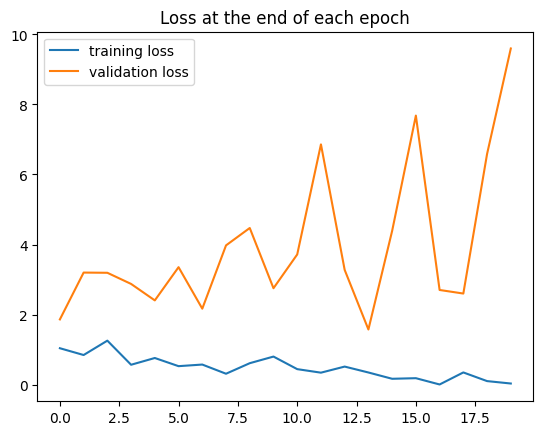

In [203]:
# train_losses
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

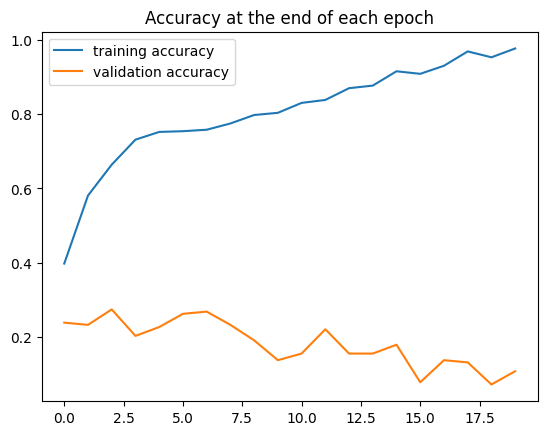

In [211]:
plt.plot([t/1009 for t in train_correct], label='training accuracy')
plt.plot([t/168 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluate Test Data

In [205]:
test_load_all = DataLoader(test_dataset, batch_size=168, shuffle=False)

In [207]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_dataset)} = {correct.item()*100/(len(test_dataset)):7.3f}%')

Test accuracy: 18/168 =  10.714%


In [208]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[   0    0    0    0    0    0]
 [   2    3    3   12    7   11]
 [  15    3    4   16   17   12]
 [  24    1    1    6    4    5]
 [   2    0    1    3    0    5]
 [   2    0    1    3    0    5]]


In [209]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

150

In [210]:
misses[:10]

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9])